In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bz = 128
crop_size = 64          # Because the input on CNN is the same, we have to specify the default 224 at the beginning


# This Pipeline augmentasi
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.,7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
# The test data should not be augmented but the input must be the same
test_transform = transforms.Compose([
    transforms.Resize(70),             # because the image resolution is different
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
train_loader = DataLoader(train_set, batch_size=bz, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
test_loader = DataLoader(test_set, batch_size=bz, shuffle=True)      # It is recommended to shuffle if you want to check our predictions

#### Check

In [4]:
feature, target = next(iter(train_loader))
feature.shape

(torch.Size([128, 3, 64, 64]),)

In [5]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Architecture CNN & Config


In [6]:
# Kalo ingin manual
# nn.Conv2d(3, 8, 1, 1) # 8 = filter
# nn.ReLU()
# nn.MaxPool2d(2, 2)

In [9]:
# Something that repeats use linear blocks
from jcopdl.layers import conv_block, linear_block

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8), # 64 channels from a 64*64 size image get pooled to 32
            conv_block(8, 16), # pool to 16
            conv_block(16, 32), # pool to 8
            conv_block(32, 64), # pool to 4
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),  # 64*4*4
            linear_block(256, 2, activation="lsoftmax")  # Ada Mish 
        )
        
    def forward(self, x):     
        x = self.conv(x) # there is data entered into the feature extractor
        x = self.fc(x)  # enter fc
        return x

In [11]:
config = set_config({
    "batch_size": bz,
    "crop_size": crop_size
})

# Training Preparation MCOC
if you don't use logsoftmax you can use crossentropy

In [14]:
model = CNN().to(device)

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config=config, outdir='model')

# Training

In [17]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6904 | Test_cost  = 0.6790 | Train_score = 0.5120 | Test_score = 0.6675 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6715 | Test_cost  = 0.6319 | Train_score = 0.6320 | Test_score = 0.6650 |
==> EarlyStop patience =  1 | Best test_score: 0.6675


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6178 | Test_cost  = 0.5726 | Train_score = 0.6790 | Test_score = 0.6950 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5747 | Test_cost  = 0.5227 | Train_score = 0.6980 | Test_score = 0.7600 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5346 | Test_cost  = 0.6037 | Train_score = 0.7530 | Test_score = 0.6825 |
==> EarlyStop patience =  1 | Best test_score: 0.7600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5656 | Test_cost  = 0.5169 | Train_score = 0.7100 | Test_score = 0.7675 |


Train:   0%|          | 0/8 [01:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5396 | Test_cost  = 0.5051 | Train_score = 0.7370 | Test_score = 0.7725 |


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.5289 | Test_cost  = 0.4656 | Train_score = 0.7380 | Test_score = 0.7950 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.5236 | Test_cost  = 0.4587 | Train_score = 0.7420 | Test_score = 0.7850 |
==> EarlyStop patience =  1 | Best test_score: 0.7950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4998 | Test_cost  = 0.4532 | Train_score = 0.7590 | Test_score = 0.8175 |


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4962 | Test_cost  = 0.4231 | Train_score = 0.7630 | Test_score = 0.8175 |
==> EarlyStop patience =  1 | Best test_score: 0.8175


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4946 | Test_cost  = 0.4117 | Train_score = 0.7550 | Test_score = 0.8150 |
==> EarlyStop patience =  2 | Best test_score: 0.8175


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4913 | Test_cost  = 0.4116 | Train_score = 0.7500 | Test_score = 0.8225 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4806 | Test_cost  = 0.3917 | Train_score = 0.7780 | Test_score = 0.8250 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.4609 | Test_cost  = 0.3969 | Train_score = 0.7720 | Test_score = 0.8325 |


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4708 | Test_cost  = 0.3744 | Train_score = 0.7630 | Test_score = 0.8400 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.4643 | Test_cost  = 0.3974 | Train_score = 0.7800 | Test_score = 0.8125 |
==> EarlyStop patience =  1 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.4464 | Test_cost  = 0.4121 | Train_score = 0.7880 | Test_score = 0.8025 |
==> EarlyStop patience =  2 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.4663 | Test_cost  = 0.3738 | Train_score = 0.7880 | Test_score = 0.8450 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.4488 | Test_cost  = 0.3950 | Train_score = 0.8110 | Test_score = 0.8125 |


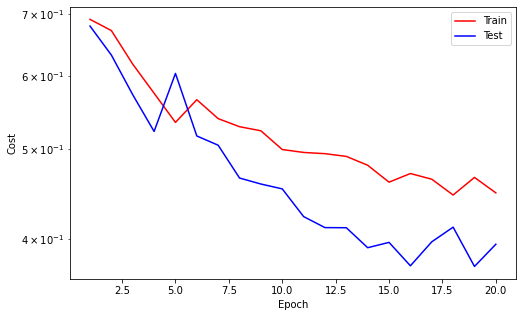

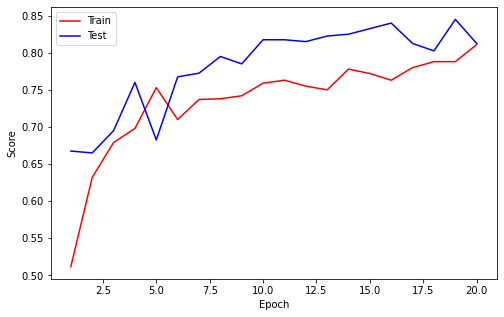

==> EarlyStop patience =  1 | Best test_score: 0.8450


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.4465 | Test_cost  = 0.3481 | Train_score = 0.7820 | Test_score = 0.8600 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.4215 | Test_cost  = 0.3332 | Train_score = 0.8100 | Test_score = 0.8675 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.4343 | Test_cost  = 0.3473 | Train_score = 0.7930 | Test_score = 0.8650 |
==> EarlyStop patience =  1 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.4371 | Test_cost  = 0.3651 | Train_score = 0.7990 | Test_score = 0.8475 |
==> EarlyStop patience =  2 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:10<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.4336 | Test_cost  = 0.3429 | Train_score = 0.8000 | Test_score = 0.8600 |
==> EarlyStop patience =  3 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.4300 | Test_cost  = 0.3395 | Train_score = 0.8020 | Test_score = 0.8800 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.4192 | Test_cost  = 0.3139 | Train_score = 0.8080 | Test_score = 0.8800 |
==> EarlyStop patience =  1 | Best test_score: 0.8800


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.3966 | Test_cost  = 0.3353 | Train_score = 0.8250 | Test_score = 0.8650 |
==> EarlyStop patience =  2 | Best test_score: 0.8800


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.4041 | Test_cost  = 0.3308 | Train_score = 0.8060 | Test_score = 0.8800 |
==> EarlyStop patience =  3 | Best test_score: 0.8800


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.4066 | Test_cost  = 0.3018 | Train_score = 0.8170 | Test_score = 0.8875 |


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.4142 | Test_cost  = 0.3210 | Train_score = 0.8230 | Test_score = 0.8975 |


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.4142 | Test_cost  = 0.2981 | Train_score = 0.8140 | Test_score = 0.8975 |
==> EarlyStop patience =  1 | Best test_score: 0.8975


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.3999 | Test_cost  = 0.3029 | Train_score = 0.8160 | Test_score = 0.8925 |
==> EarlyStop patience =  2 | Best test_score: 0.8975


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.3605 | Test_cost  = 0.2818 | Train_score = 0.8390 | Test_score = 0.9000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.3744 | Test_cost  = 0.3061 | Train_score = 0.8290 | Test_score = 0.8725 |
==> EarlyStop patience =  1 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:10<?, ?it/s]


Epoch    36
Train_cost  = 0.3763 | Test_cost  = 0.3152 | Train_score = 0.8400 | Test_score = 0.8575 |
==> EarlyStop patience =  2 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.3581 | Test_cost  = 0.2697 | Train_score = 0.8420 | Test_score = 0.9000 |
==> EarlyStop patience =  3 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:01<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.3639 | Test_cost  = 0.3457 | Train_score = 0.8410 | Test_score = 0.8350 |
==> EarlyStop patience =  4 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.3967 | Test_cost  = 0.3665 | Train_score = 0.8170 | Test_score = 0.8450 |
==> EarlyStop patience =  5 | Best test_score: 0.9000
==> Execute Early Stopping at epoch: 39 | Best test_score: 0.9000
==> Best model is saved at model


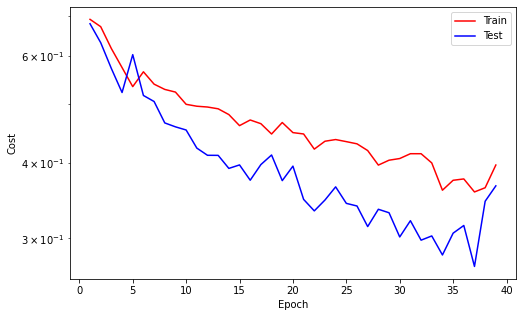

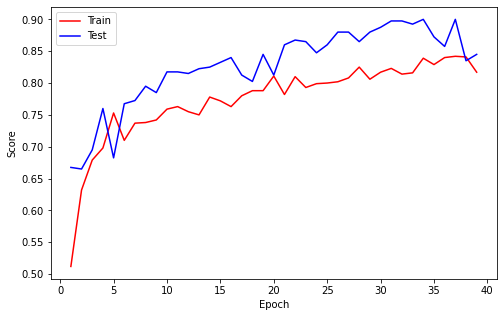

In [19]:
while True:
    train_loss, train_acc = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_loss, test_acc = loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)
            
    # Logging
    callback.log(train_loss, test_loss, train_acc, test_acc)
    
    # Checkpoint Untuk training yang lama untuk aman
    callback.save_checkpoint()
    
    # Runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early stoping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

Misal gambar kucing ingin mengenal ada kucing, ikan dan anjing namanya Image recognition, image detection lokasi, image segmention objecknya diwarnai

kenapa test lebih bagus karena urutan loop

In [21]:
feature, target = next(iter(test_loader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninva

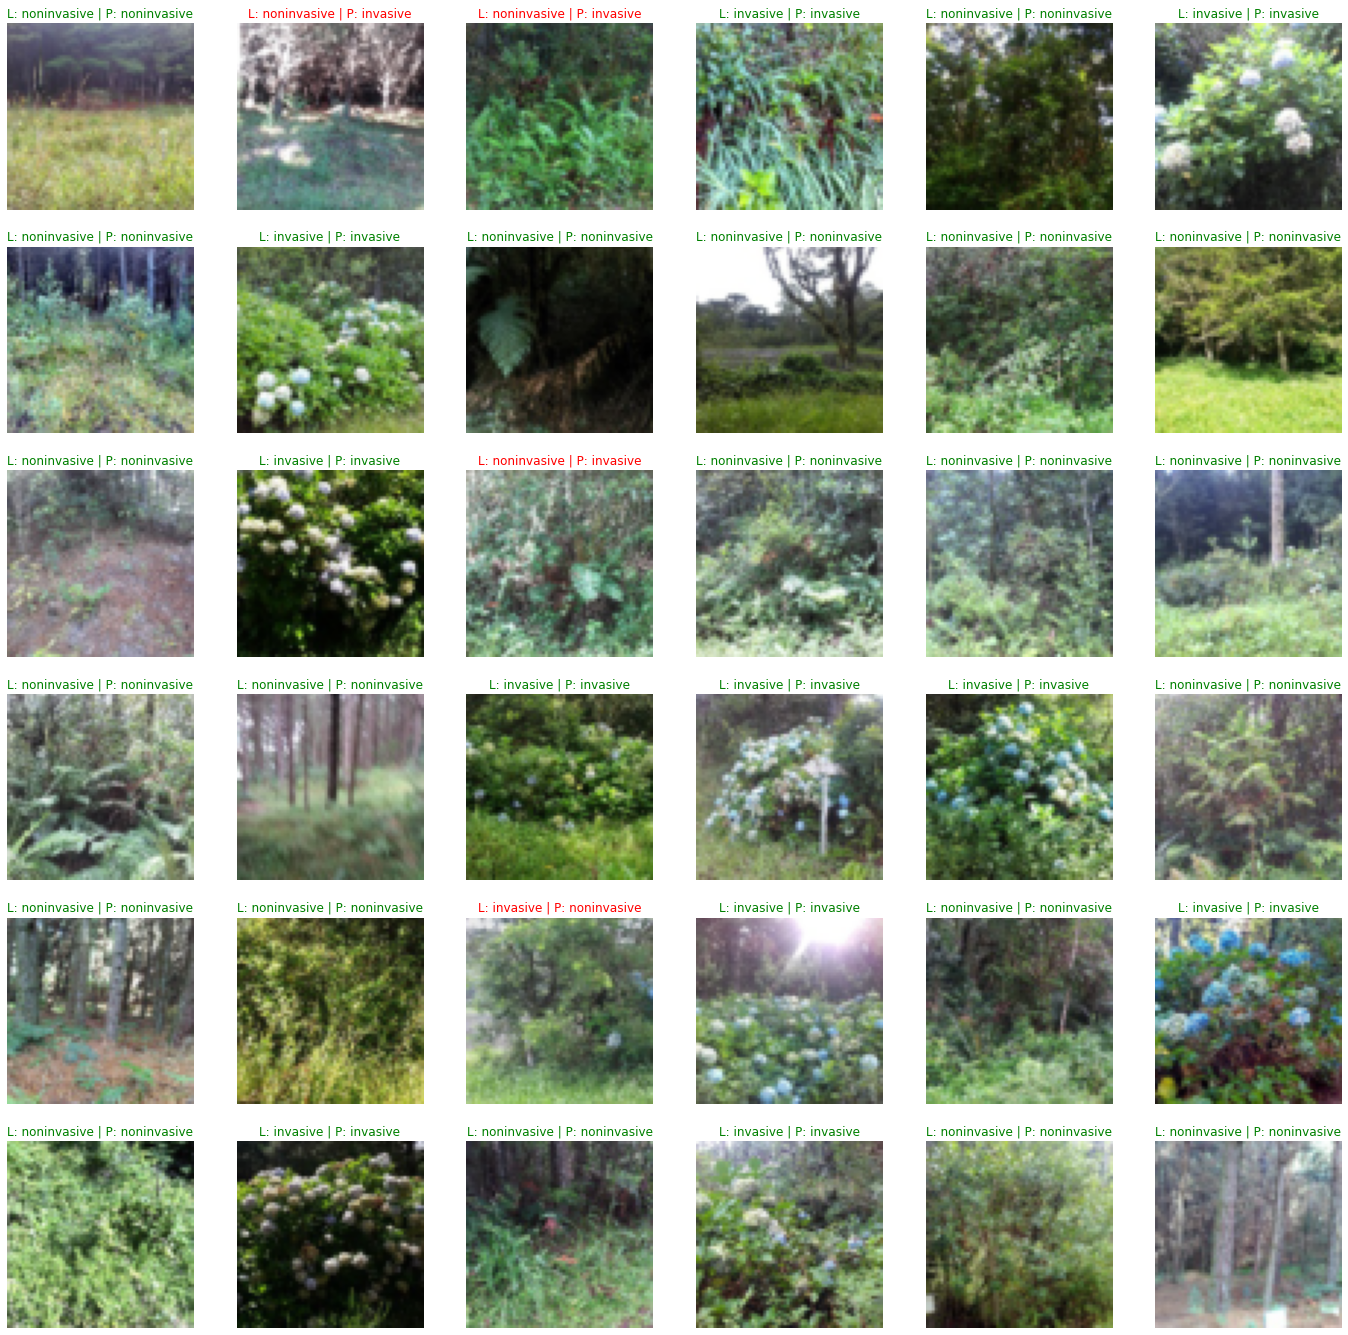

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {"color":"r"} if label != pred else {"color":"g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis("off");